In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow import keras

from transformers import TFAutoModel, AutoTokenizer
import tensorflow as tf  # Needed for Dataset API


2025-03-16 13:06:06.776078: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-16 13:06:06.784146: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742155566.793067 1054612 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742155566.795669 1054612 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742155566.802469 1054612 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# Disaster Tweets EDA

**THE GOAL**: Given a set of tweets, train a model to classify tweets as *Emergency* or *Not Emergency*.

First we'll look at the data. See how it's distributed and look for outliers. Next, we'll figure out a plan on a model. We'll compare a baseline and a different model trained on different data. Then we'll write down some concouslins and further worker.

## The Data

the data itself is laid out pretty simply

    data/
    ├── sample_submission.csv
    ├── test.csv
    └── train.csv

The data is laid out into CSVs. The headers are **id,keyword,location,text,target**

In [38]:
df_train = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


We can see that we don't have a lot of training data. 

A typical example from the training data is

    10358,
    weapons,,
    Ukraine argues for US weapons during Pelosi's visit to Kiev http://t.co/jnN0kRNXvY http://t.co/5LOiWuyv5r,
    1

Formatted for clarity. 


### Location Data

After a glance, there doesn't seem to be any real correlation between locations labels. In certain cases, in areas where a conflict may occur could strongly indicate a positive classification. However, since the data was collected in 2019, none of the labels include any 'hot' areas of the world in 2025. 

We can also see from the data description, we are missing half of the location. This alone makes the location data not as useful.

#### Proof

So we say the location data is not important. How can we prove it? We shall use p-statistics.

Chi-Square Test p-value: 0.01300195417927766


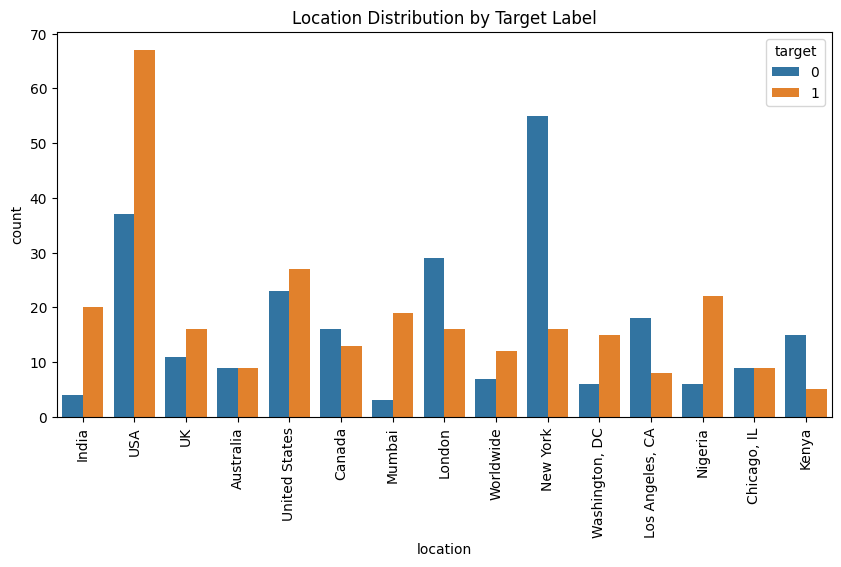

In [39]:
import scipy.stats as stats

# Count occurrences of each location grouped by target label
contingency_table = pd.crosstab(df_train["location"], df_train["target"])

# Run the Chi-Square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Print the p-value
print(f"Chi-Square Test p-value: {p}")

import seaborn as sns
import matplotlib.pyplot as plt

# Plot the top 15 locations by count
top_locations = df_train["location"].value_counts().nlargest(15).index

plt.figure(figsize=(10, 5))
sns.countplot(data=df_train[df_train["location"].isin(top_locations)], x="location", hue="target")
plt.xticks(rotation=90)
plt.title("Location Distribution by Target Label")
plt.show()

It seems like location may actually be important. Since the chi is showing a p-statistic, since the value si less than .05, we definitely have a real relationship. But looking closely at the graphs, we can see that USA is a huge margin by far. This happens for a few other locations that are heavily skewed towards one label. 

During 2019 we had large fires in places like the US and Australia, and certain politics were hapenning causing great issues in the US, but not rising to the level of an emergency such as a forest fire. 

*We May conclude that location is important but only at the time it was collected.* 

That is, while past data indicates 'hot conflict zones' , it won't in the future. we'd have to re-train the model every year or so to get used to new hotspots and forget old ones. This data set will not be useful in 2025. For example, 'Ukraine' only appears 8 times in the training data.

We also note that tiwtter is an american website. It's mostly about US topiccs and so that skews any predictive power. Apparently, Japan is the #2 user of the platform[1]. Certainly an emergency happened in Japan? Yet it does not seem apparent from the above graph. With the third largest user base of India, we *do* see some Indian cities mentioned. 

We shall take out some of the really imbalanced labels and see if that changes things.

1 - https://www.statista.com/statistics/242606/number-of-active-twitter-users-in-selected-countries/

Chi-Square Test p-value: 0.05114935391221743


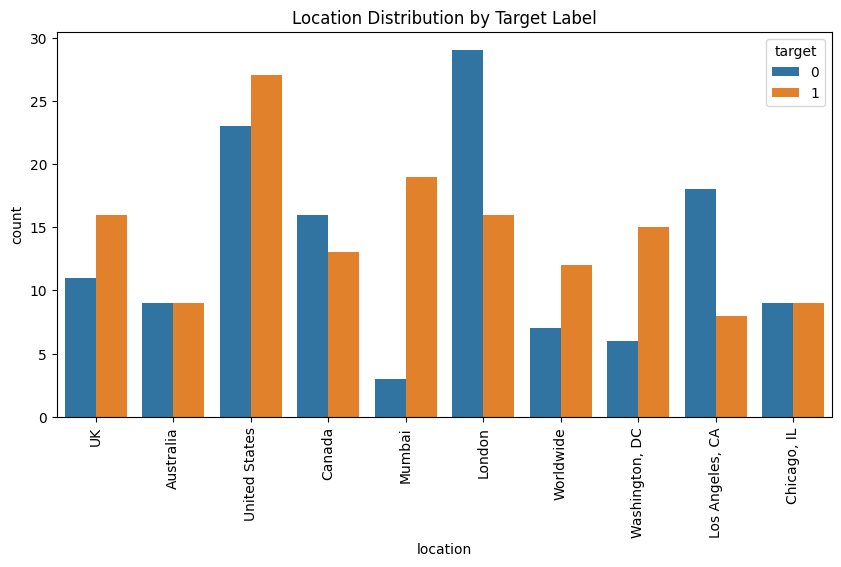

In [33]:

locations_to_remove = ["New York", "USA", "India", "Nigeria", "Kenya"]

df_train_no_usa = df_train[~df_train["location"].isin(locations_to_remove)]

import scipy.stats as stats


# Count occurrences of each location grouped by target label
contingency_table = pd.crosstab(df_train_no_usa["location"], df_train_no_usa["target"])

# Run the Chi-Square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Print the p-value
print(f"Chi-Square Test p-value: {p}")

import seaborn as sns
import matplotlib.pyplot as plt

# Plot the top 15 locations by count
top_locations = df_train["location"].value_counts().nlargest(15).index

plt.figure(figsize=(10, 5))
sns.countplot(data=df_train_no_usa[df_train_no_usa["location"].isin(top_locations)], x="location", hue="target")
plt.xticks(rotation=90)
plt.title("Location Distribution by Target Label")
plt.show()

As you can see, the issue goes away if we get rid of the first few imbalacned locations such as USA or India. In general we would want to see really balanced labels, such as Chicago.

*It may be better to sort tweets by location*. That is, we should do this analysis by region, too.

Since we don't have good location data to labels, then we won't include the location as part of our training data.


In [34]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [35]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


#### Conclusion

We can skip the location data for now. 

Getting tweets with location data more evenly balanced would be preferable. There *probably* is some useful data hidden there.

Tweet data is temporal, a reflection of the times they are created. Location data is not so useful.

## Data Clean Up
Let's do some cleanup. By removing URLS and @ mentions, hashtags, and weird charachters that aren't whitespce or printable chars. 

Finally we shall do a test train split.

In [6]:


from sklearn.model_selection import train_test_split

# X = df_train["text"]
# y = df_train["target"]

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

# X_test = df_test["text"]

import re

def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"https?://\S+|www\.\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove @mentions
    text = re.sub(r"#\w+", "", text)  # Remove hashtags (or keep words if useful)
    text = re.sub(r"[^\w\s]", "", text)  # Remove special characters
    return text

# Apply cleaning
df_train["clean_text"] = df_train["text"].apply(clean_text)
df_test["clean_text"] = df_test["text"].apply(clean_text)

# Use cleaned text for training & testing
X_train, X_val, y_train, y_val = train_test_split(df_train["clean_text"], df_train["target"], test_size=VAL_SPLIT, random_state=42)
X_test = df_test["clean_text"]



## The Approach

Let's use a pretrained model to get a baseline. I also want to try a different model trained specifically on social media. 

Here are some preliminary settings.

In [36]:

BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.9
VAL_SPLIT = 0.1
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 20
AUTO = tf.data.experimental.AUTOTUNE

Why use batch size 32, epoch? A typical approach.

Why use 90/10 split? We don't have much data overall.

## BERT & friends

We shall use the BERT model since it's pretty well trained on text. 

We will use huggingface's 'distilbert-base-uncased' model. It's a tiny but powerful model, 97% as good as the big BERT model[2]. 

### What makes BERT so great? 

BERT was one of the first big models that used attention to look at the context of a word in a sentance. Google trained it on as much as text as possible. 

This particular distilbert model also has excellent classification abilities. From the paper,

    As shown in Table 2, DistilBERT is only 0.6% point behind BERT in test accuracy on the IMDb
    benchmark while being 40% smaller. On SQuAD, DistilBERT is within 3.9 points of the full BERT

**tl;dr**: Great text-based classification, uses attention to really grasp nuance in a senatnce.

2- https://arxiv.org/abs/1910.01108

In [7]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

# # Choose a pretrained BERT model (small, optimized for text classification)
# MODEL_NAME = "distilbert-base-uncased"

# # Load tokenizer & model
# tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# bert_model = TFAutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

MODEL_NAME = "bert-base-uncased"  # More powerful than DistilBERT
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert_model = TFAutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)


I0000 00:00:1742155568.571508 1054612 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8911 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
import tensorflow as tf

# Tokenize training dataset
train_encodings = tokenizer(list(df_train["text"]), truncation=True, padding=True, max_length=128, return_tensors="tf")
train_labels = tf.convert_to_tensor(df_train["target"].values)

# Tokenize test dataset
test_encodings = tokenizer(list(df_test["text"]), truncation=True, padding=True, max_length=128, return_tensors="tf")


In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).batch(16)  # Adjust batch size as needed


In [10]:

# Learning rate scheduler
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=2e-5, decay_steps=1000, decay_rate=0.9
)

# Use AdamW optimizer (better for Transformers)
optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_scheduler)

# Compile the model
# optimizer = keras.optimizers.Adam(learning_rate=2e-5)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

# Train the model
bert_model.fit(train_dataset, epochs=EPOCHS)


Epoch 1/20


I0000 00:00:1742155580.003750 1054821 service.cc:152] XLA service 0x780488b42510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742155580.003763 1054821 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 Laptop GPU, Compute Capability 8.9
2025-03-16 13:06:20.007411: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742155580.019177 1054821 cuda_dnn.cc:529] Loaded cuDNN version 90600
I0000 00:00:1742155580.094194 1054821 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


476/476 [==============================] - 69s 96ms/step - loss: 0.4916 - accuracy: 0.7791
Epoch 2/20
476/476 [==============================] - 36s 77ms/step - loss: 0.3500 - accuracy: 0.8587
Epoch 3/20
476/476 [==============================] - 36s 76ms/step - loss: 0.2694 - accuracy: 0.8989
Epoch 4/20
476/476 [==============================] - 37s 78ms/step - loss: 0.1969 - accuracy: 0.9288
Epoch 5/20
476/476 [==============================] - 37s 78ms/step - loss: 0.1458 - accuracy: 0.9480
Epoch 6/20
476/476 [==============================] - 37s 78ms/step - loss: 0.0982 - accuracy: 0.9665
Epoch 7/20
476/476 [==============================] - 37s 77ms/step - loss: 0.0782 - accuracy: 0.9720
Epoch 8/20
476/476 [==============================] - 37s 78ms/step - loss: 0.0707 - accuracy: 0.9728
Epoch 9/20
476/476 [==============================] - 37s 78ms/step - loss: 0.0586 - accuracy: 0.9779
Epoch 10/20
476/476 [==============================] - 37s 77ms/step - loss: 0.0495 - accurac

In [11]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))


24/24 [==============================] - 2s 29ms/step


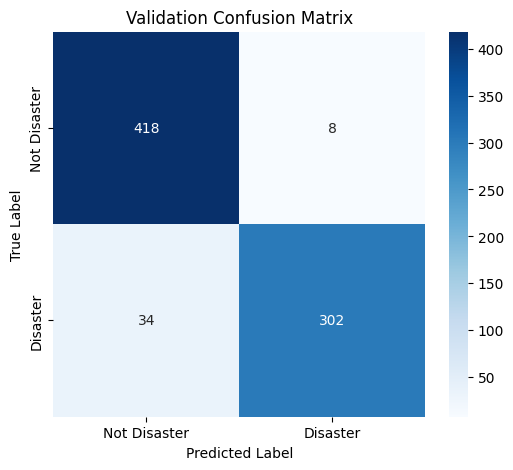

              precision    recall  f1-score   support

Not Disaster       0.92      0.98      0.95       426
    Disaster       0.97      0.90      0.93       336

    accuracy                           0.94       762
   macro avg       0.95      0.94      0.94       762
weighted avg       0.95      0.94      0.94       762



In [12]:


# y_pred_train = bert_model.predict(X_train)

from transformers import AutoTokenizer

# Load tokenizer
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Tokenize validation set
val_encodings = tokenizer(
    list(X_val), truncation=True, padding=True, max_length=128, return_tensors="tf"
)

# Convert validation labels to Tensor
import tensorflow as tf
y_val_tensor = tf.convert_to_tensor(y_val.values)


import numpy as np

# Get model predictions (logits)
val_preds = bert_model.predict(dict(val_encodings)).logits

# Convert logits to class predictions (0 or 1)
val_preds = np.argmax(val_preds, axis=1)

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_val, val_preds)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Disaster", "Disaster"], yticklabels=["Not Disaster", "Disaster"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Validation Confusion Matrix")
plt.show()

print(classification_report(y_val, val_preds, target_names=["Not Disaster", "Disaster"]))


Hey not so bad! This is a pretty high 0.95 f1 score. 

### Conclusion

The BERT model we have is pretty good at classification with minimal pre-processing. 
We also didn't have a ton of data to work wth in the first place.

Despite this BERT is pretty good as a baseline.


## Results

Let's Submitt this and get the results

In [13]:
# Tokenize test dataset
test_encodings = tokenizer(
    list(X_test), truncation=True, padding=True, max_length=128, return_tensors="tf"
)


In [49]:
# Get raw model predictions (logits)
test_preds = bert_model.predict(dict(test_encodings)).logits

# Convert logits to class predictions (0 = not disaster, 1 = disaster)
test_preds = np.argmax(test_preds, axis=1)


102/102 [==============================] - 4s 37ms/step


In [48]:
# Create submission DataFrame
submission = pd.DataFrame({
    "id": df_test["id"],  # Use the original test set IDs
    "target": test_preds  # Model predictions
})

# Save to CSV (without index)
submission.to_csv("submission.csv", index=False)

print("💀 Submission file saved as submission.csv! 💀")


💀 Submission file saved as submission.csv! 💀


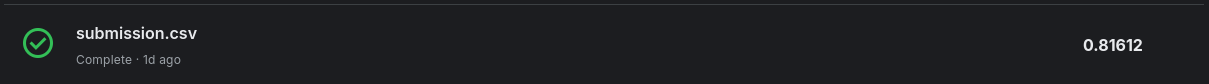

In [60]:
from IPython.display import Image

# Display the results
Image(filename="./results.png")


### Why do we get the score we do?

Let's first look at what got mis-classified. Perhaps a pattern will arise.


In [58]:
# Convert validation set into a Pandas DataFrame
df_val = pd.DataFrame({"text": X_val, "true_label": y_val.values, "predicted_label": val_preds})

# Find misclassified tweets
misclassified_tweets = df_val[df_val["true_label"] != df_val["predicted_label"]]

# Display misclassified tweets
pd.set_option("display.max_colwidth", None)
print(misclassified_tweets[['text', 'true_label', 'predicted_label']])


                                                                                                                             text  \
1765                       my favorite lady came to our volunteer meeting\nhopefully joining her youth collision and i am excite    
1817   ux fail of emv  people want to insert and remove quickly like a gas pump stripe reader 1 person told me it crashed the pos   
3105                                                                                                      woman electrocuted        
4019    who is bringing the tornadoes and floods who is bringing the climate change god is after america he is plaguing her\n \n    
2534                                          escape the heat and the  for a trail run on desolation loop youll be glad you did     
...                                                                                                                           ...   
6915                                                     good to hear


Seems like sarcasam is lost on the bert model. How about i f we use a different model?

## A social media Model: Roberta

Roberta is an improved model of Bert created by Meta[3]. Some improvements are larger corpus of training data, much longer training time, and the quality of that training data was different, too.


3 - https://arxiv.org/abs/1907.11692

In [18]:
MODEL_NAME = "roberta-base"  # Alternative: "vinai/bertweet-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert_model = TFAutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti


To really squeeze more performance, we will use the Adam optimizer instead of SGD. We will aos use learning rate scheduling


In [19]:

# Learning rate scheduler
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=2e-5, decay_steps=1000, decay_rate=0.9
)

# Use AdamW optimizer (better for Transformers)
optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_scheduler)

# Compile the model
# optimizer = keras.optimizers.Adam(learning_rate=2e-5)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

# Tokenize training & validation data
train_encodings = tokenizer(
    list(X_train), truncation=True, padding=True, max_length=128, return_tensors="tf"
)
val_encodings = tokenizer(
    list(X_val), truncation=True, padding=True, max_length=128, return_tensors="tf"
)

# Convert labels to TensorFlow tensors
train_labels = tf.convert_to_tensor(y_train.values)
val_labels = tf.convert_to_tensor(y_val.values)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings), train_labels
)).shuffle(1000).batch(16).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings), val_labels
)).batch(16).prefetch(tf.data.AUTOTUNE)

# Train the model
bert_model.fit(train_dataset, epochs=EPOCHS)


Epoch 1/20
429/429 [==============================] - 61s 90ms/step - loss: 0.4631 - accuracy: 0.7929
Epoch 2/20
429/429 [==============================] - 32s 74ms/step - loss: 0.3588 - accuracy: 0.8524
Epoch 3/20
429/429 [==============================] - 30s 70ms/step - loss: 0.2964 - accuracy: 0.8840
Epoch 4/20
429/429 [==============================] - 30s 71ms/step - loss: 0.2314 - accuracy: 0.9076
Epoch 5/20
429/429 [==============================] - 31s 72ms/step - loss: 0.1795 - accuracy: 0.9317
Epoch 6/20
429/429 [==============================] - 31s 73ms/step - loss: 0.1390 - accuracy: 0.9491
Epoch 7/20
429/429 [==============================] - 30s 71ms/step - loss: 0.0998 - accuracy: 0.9650
Epoch 8/20
429/429 [==============================] - 30s 71ms/step - loss: 0.0954 - accuracy: 0.9635
Epoch 9/20
429/429 [==============================] - 30s 70ms/step - loss: 0.0812 - accuracy: 0.9669
Epoch 10/20
429/429 [==============================] - 30s 70ms/step - loss: 0.072

24/24 [==============================] - 1s 36ms/step


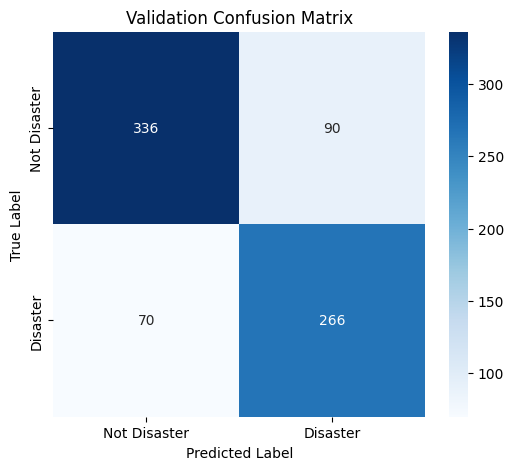

              precision    recall  f1-score   support

Not Disaster       0.83      0.79      0.81       426
    Disaster       0.75      0.79      0.77       336

    accuracy                           0.79       762
   macro avg       0.79      0.79      0.79       762
weighted avg       0.79      0.79      0.79       762



In [52]:

# Get model predictions (logits)
val_preds = bert_model.predict(dict(val_encodings)).logits

# Convert logits to class predictions (0 or 1)
val_preds = np.argmax(val_preds, axis=1)

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_val, val_preds)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Disaster", "Disaster"], yticklabels=["Not Disaster", "Disaster"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Validation Confusion Matrix")
plt.show()

print(classification_report(y_val, val_preds, target_names=["Not Disaster", "Disaster"]))

In [55]:
# Get raw model predictions (logits)
test_preds = bert_model.predict(dict(test_encodings)).logits

# Convert logits to class predictions (0 = not disaster, 1 = disaster)
test_preds = np.argmax(test_preds, axis=1)

# Create submission DataFrame
submission = pd.DataFrame({
    "id": df_test["id"],  # Use the original test set IDs
    "target": test_preds  # Model predictions
})

# Save to CSV (without index)
submission.to_csv("submission.csv", index=False)

print("🏁 Submission file saved as submission.csv! 🏁")

102/102 [==============================] - 4s 35ms/step
🏁 Submission file saved as submission.csv! 🏁


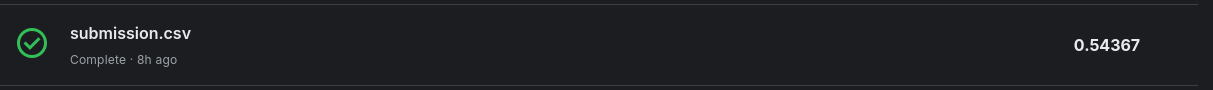

In [61]:
Image(filename="./blah.png")


Well, sometimes things don't work out. With a kaggle score of 0.54, it's little better than a coin toss.

The results we got from Roberta were not nearly as good


## Conclusions and Further Work

We can conclude that a RNN Bert Transformer model is indeed good at classification with minimal work. Roberta model may be useful but prooved inconclusive so far.

*It may be better to sort tweets by location*. That is, we should do this analysis by region, too.

*We need more Data*: this is a tough challenge because of the small amount of training data. 

### Disparity in Roberta and BERT

There were some mis-classifications for sarcasm in the BERT model. However, most genine emergencies tend to be more matter of fact with much less ambiguity. most FB posts may be *too* sarcastic. Originaly, i wanted to see if a model trained on social media could handle the sarcsm. Apparently not.

The BERT modesl are trained on more 'neutral' data sets. This neutrality is more inline with tweets describing an emergency rather than sarcastic FB posts.

### Future work
**Translate back and forth to synthesize more data.** We can translate our tweet into a foreign language, then translate it back. hopefully the semantics will be the same and we can use this translation as an extra data record.

**Retrain with location data-only entries**. We know that location data can be useful, certainly at the time of data collection, we can get an idea of an emergency like a wildfire in the US or Australia in 2019. 

**Reduce the number of categories of location data**. We can see the location data has USA and 'America' when we really mean the same thing.

**Transfer learn the Tweet Data**: We can re-cycle the lower levels of a neural network. With BERT we can use the fundamental sentance structure and semantics without worrying about overfitting the small amount of data we give it.

**Another option is to Transfer learn location data only** Similar to the previous methods but we can try with just location data.

**Create an ensemble model**: What if we got BERT and Roberta to work together. It'd be a matter of taking the average of their output scores and turning that into a 1 or a 0. It could be as simple as:

    np.round((df_bert + df_robert) / 2 )


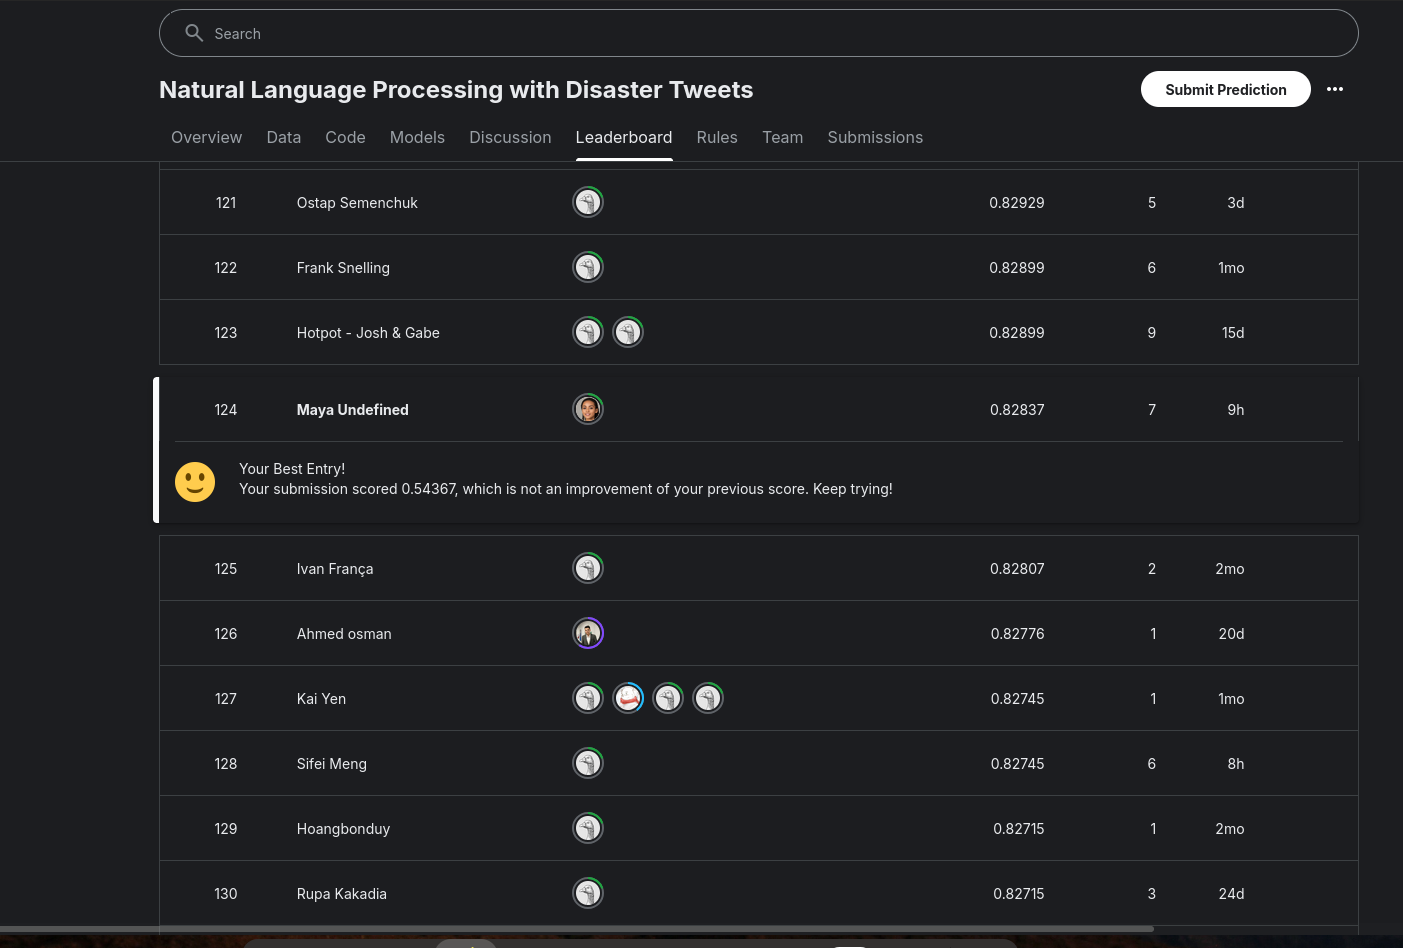

In [62]:
Image("./leaderboard.png")